In [1]:
import pygmt
import pandas as pd
import numpy as np
import scipy
from scipy.spatial import cKDTree
from matplotlib.path import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import xarray as xr
import verde as vd
# For projecting data
import pyproj
# For fetching sample datasets
#import ensaio
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import LogNorm, PowerNorm
#import dask

# Load Moho Data from Receiver Function Studies

In [2]:
#Loading only Lat, Long, Moho_km
# Define file path
#path_to_data_file = r"D:\Amitava_Laptop\Geodynamics-Project-IISERP\India_Tibet\Global_crust.csv"
#path_to_data_file = r"D:\Amitava\Projects\Spline_Moho\Global_moho_compilation\Global_crust.csv"
path_to_data_file = r"D:\Amitava\Projects\Spline_Moho\Global_moho_compilation\Global_crust_Hk.csv" # dataset with only Hk

# Load only required columns while ignoring commented lines
#data_eq_raw = pd.read_csv(path_to_data_file, comment='#', usecols=["Lat", "Long", "Moho_km"])
data_eq_all = pd.read_csv(path_to_data_file, comment='#', usecols=["Lat", "Long", "Moho_km"])
'''
# Convert Moho_km to numeric, forcing non-numeric values to NaN
#data_eq_raw["Moho_km"] = pd.to_numeric(data_eq_raw["Moho_km"], errors="coerce")
data_eq["Moho_km"] = pd.to_numeric(data_eq_raw["Moho_km"], errors="coerce")

# Drop rows with NaN values in Moho_km
data_eq_all = data_eq_raw.dropna(subset=["Moho_km"]).reset_index(drop=True)

# Check for duplicate (Lat, Long, Moho_km) groups
duplicate_mask = data_eq_all.duplicated(subset=["Lat", "Long", "Moho_km"], keep=False)

# Count duplicate entries
num_duplicates = duplicate_mask.sum()
# Count unique groups that are duplicated
num_repeated_groups = data_eq_all.loc[duplicate_mask, ["Lat", "Long", "Moho_km"]].drop_duplicates().shape[0]

print(f"Total number of repeated (Lat, Long, Moho_km) rows: {num_duplicates}")
print(f"Number of unique (Lat, Long, Moho_km) groups that are repeated: {num_repeated_groups}")

# Keep only the first occurrence of each duplicate group
data_eq = data_eq_all.drop_duplicates(subset=["Lat", "Long", "Moho_km"], keep="first").reset_index(drop=True)
'''
# Display the final DataFrame

# Filter data based on longitude and latitude
data_eq_ind = data_eq_all[
    (data_eq_all["Long"] >= 65) & (data_eq_all["Long"] <= 110) & 
    (data_eq_all["Lat"] >= 5) & (data_eq_all["Lat"] <= 45)
].reset_index(drop=True)

data_eq = data_eq_ind
eq_info = data_eq
data_eq

Lat      Long  Moho_km
0      5.1800   96.9600     38.2
1      5.2288   96.9472     31.9
2      5.2900  100.6490     33.8
3      5.2902  100.6490     32.8
4      6.0870   80.6810     36.7
...       ...       ...      ...
5044  45.0000   82.0000     44.4
5045  45.0000   82.5000     36.8
5046  45.0000   83.0000     43.4
5047  45.0000   90.5000     41.0
5048  45.0000  107.1000     41.4

[5049 rows x 3 columns]

In [3]:
'''
# Count lines starting with '#'
num_commented_lines = sum(1 for line in open(path_to_data_file, 'r') if line.startswith('#'))

# Count NaN values in Moho_km
num_nans = data_eq_raw["Moho_km"].isna().sum()

print(f"Number of lines ignored due to comments: {num_commented_lines}")
print(f"Number of NaN values in Moho_km: {num_nans}")
'''

'\n# Count lines starting with \'#\'\nnum_commented_lines = sum(1 for line in open(path_to_data_file, \'r\') if line.startswith(\'#\'))\n\n# Count NaN values in Moho_km\nnum_nans = data_eq_raw["Moho_km"].isna().sum()\n\nprint(f"Number of lines ignored due to comments: {num_commented_lines}")\nprint(f"Number of NaN values in Moho_km: {num_nans}")\n'

In [4]:
#region = [65, 110, 5, 45]
region = [-180, 180, -90, 90]  # Covers the whole world
#region = [-180, 180, -89.9, 89.9] #avoids the poles
print(region)

[-180, 180, -90, 90]


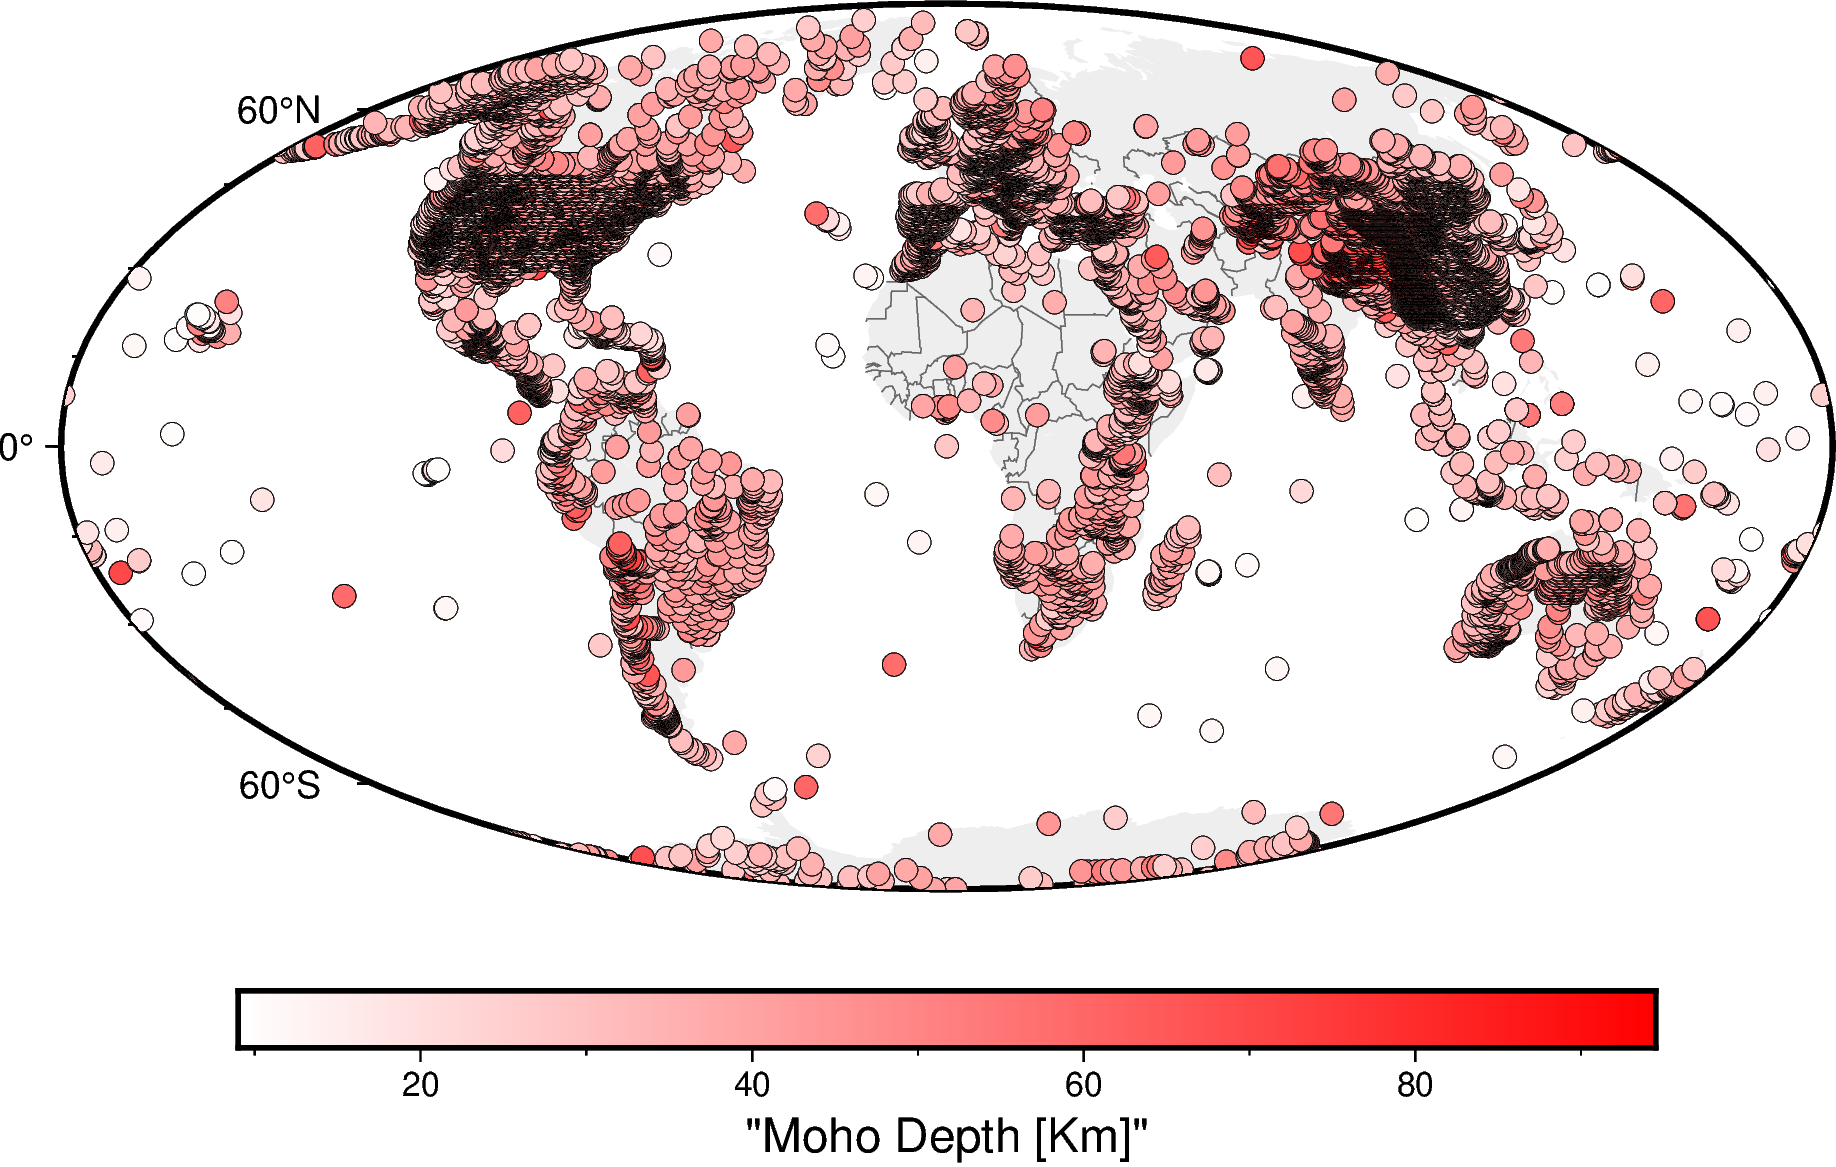

In [5]:

# Start a figure
fig = pygmt.Figure()
# Add a basemap with the data region, Mercator projection, default frame
# and ticks, color in the continents, and display national borders
fig.coast(
    region=region, projection="W15c", frame="af",
    land="#eeeeee", borders="1/#666666", area_thresh=1e4,
)
# Create a colormap for the Moho Depth
pygmt.makecpt(
    cmap="polar+h",
    series=[data_eq_all.Moho_km.min(), data_eq_all.Moho_km.max()],
    #series = [data.iloc[:, 5].min(), data.iloc[:, 5].max()],
)
# Plot colored points for the velocities
fig.plot(
    x=data_eq_all.Long,
    y=data_eq_all.Lat,
    fill=data_eq_all.Moho_km,
    style="c0.2c",
    cmap=True,
    pen="0.001p,black",
)
# Add a colorbar with automatic frame and ticks and a label
fig.colorbar(frame='af+l"Moho Depth [Km]"')
fig.show()


# Load Topography

## pyGMT

In [6]:
#topography =pygmt.datasets.load_earth_relief(resolution="01m", region="g")

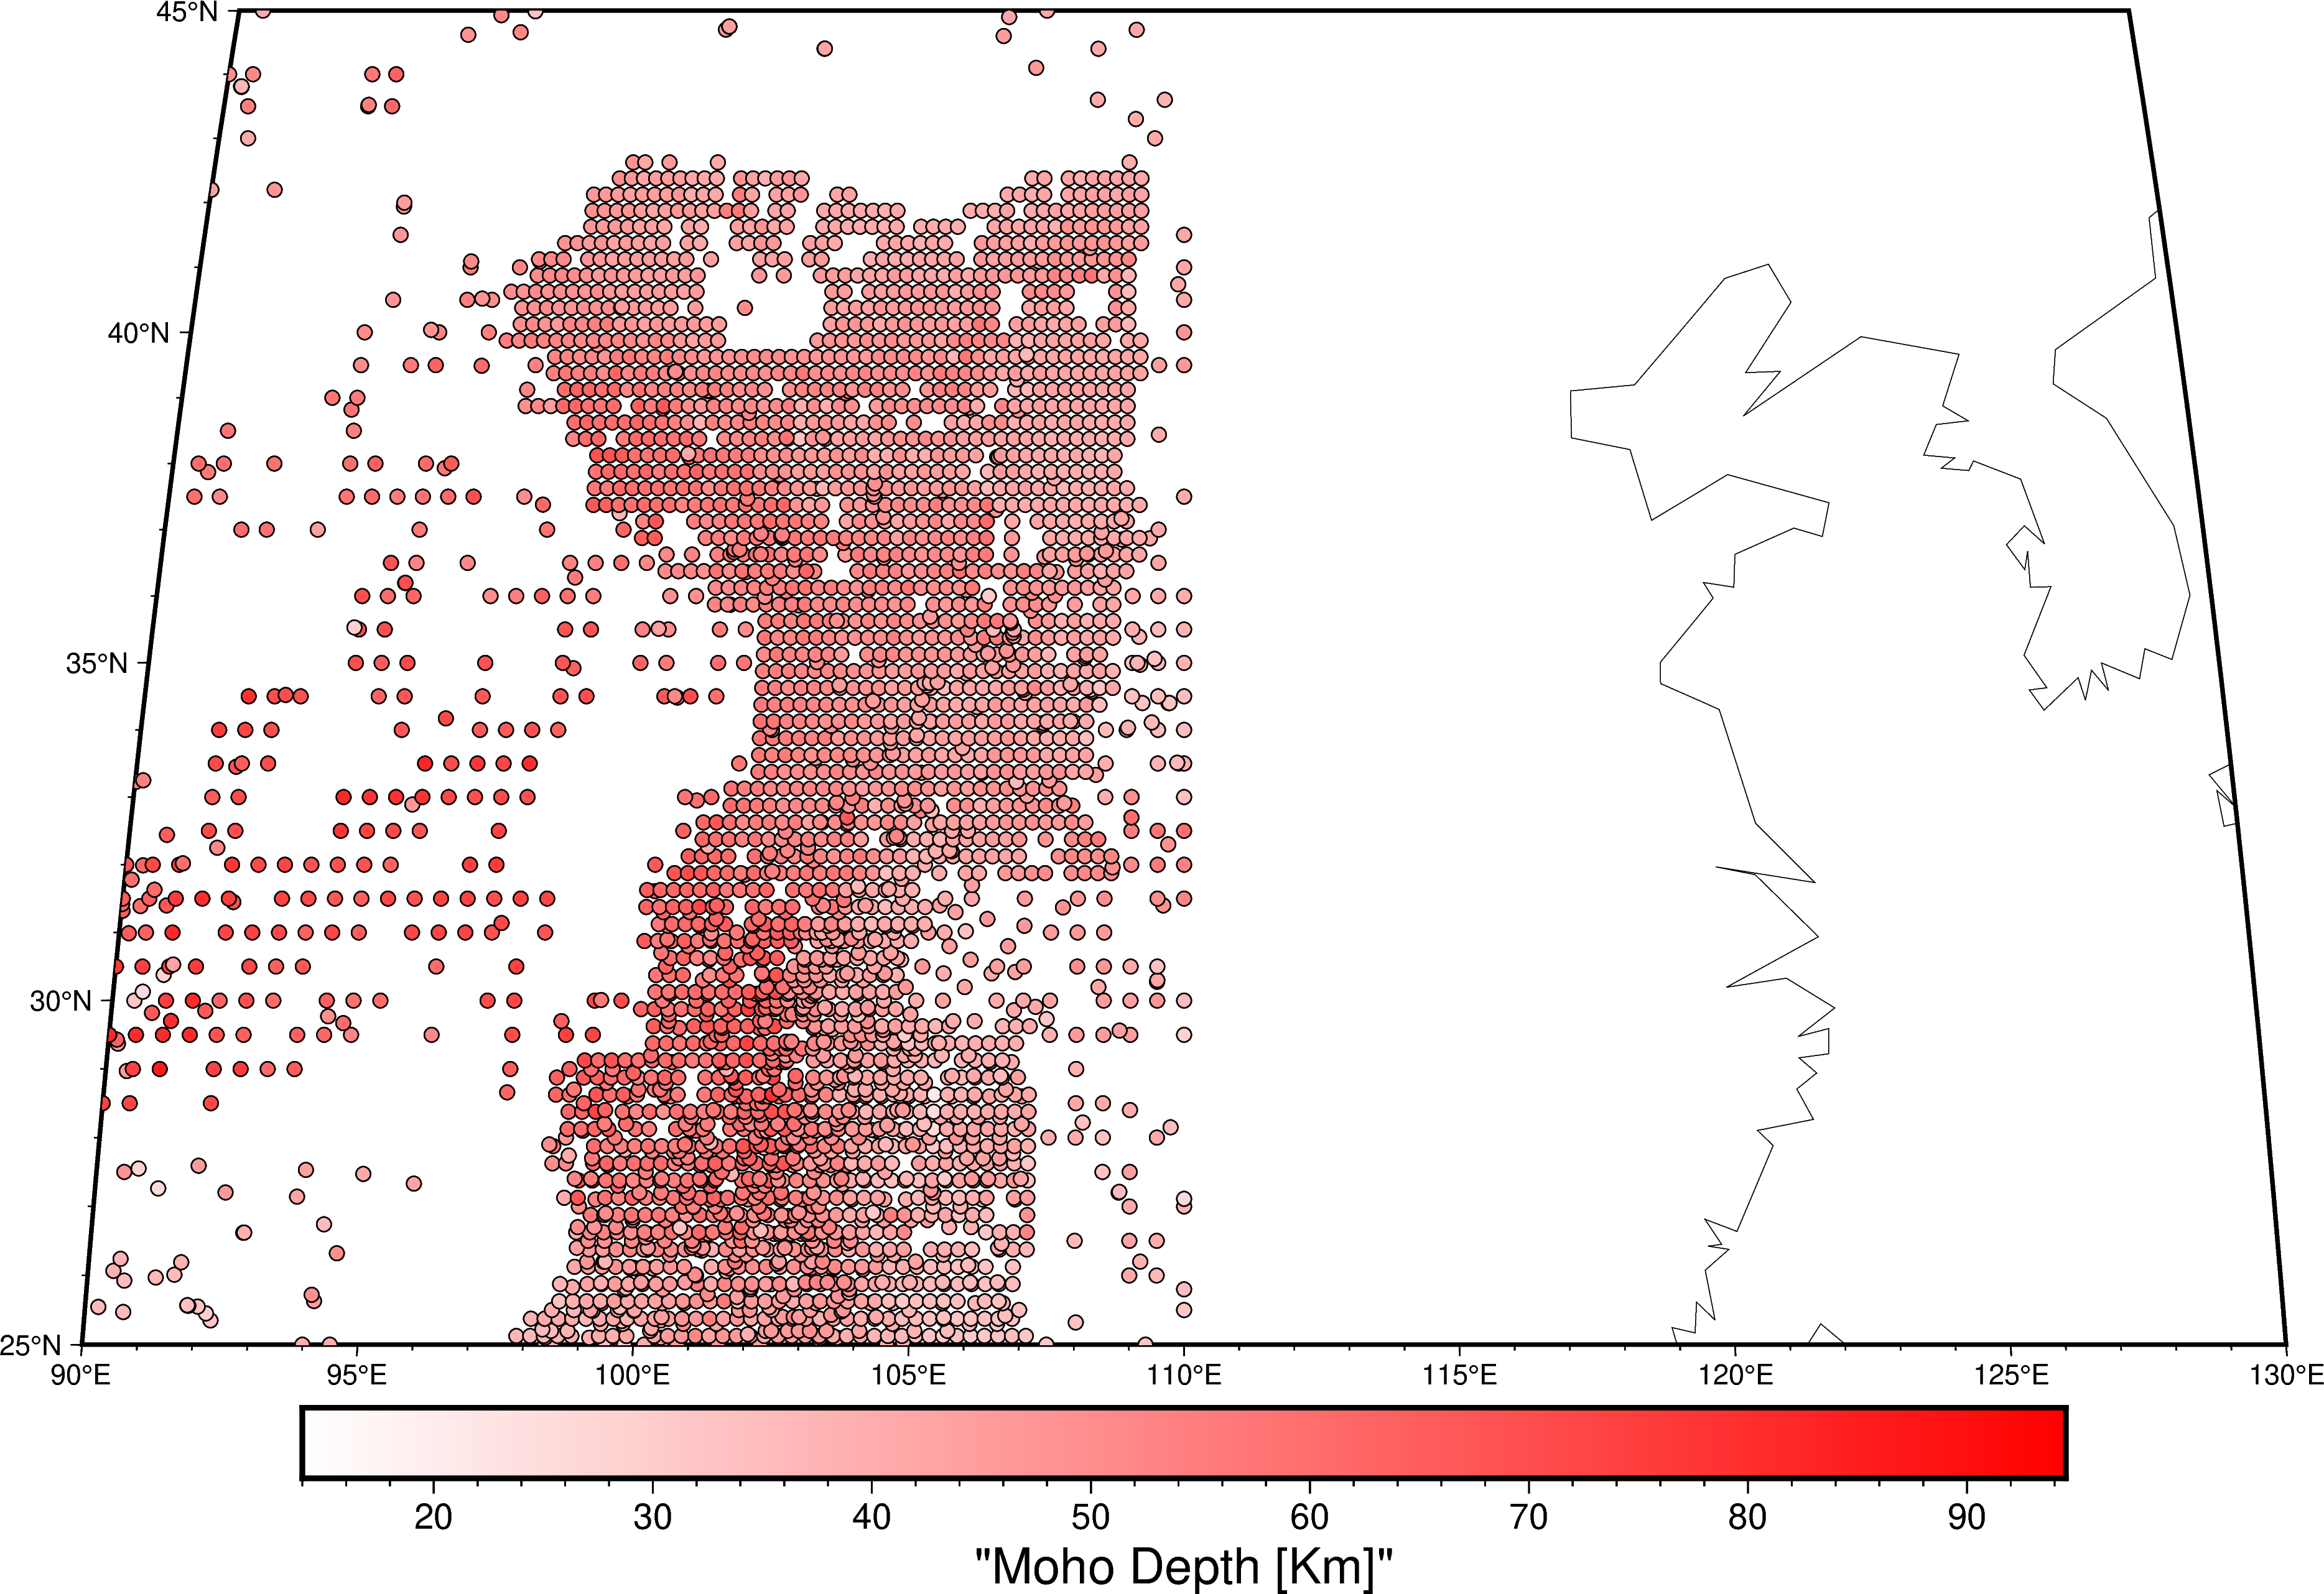

In [7]:
fig = pygmt.Figure()
fig.basemap(
    #region="g", # for the entire world
    region = [90, 130, 25, 45], #[Min Longitude, Max Longitude, Min Latitude, Max Latitude]
    projection="W30c",
    frame=True,
)
#fig.grdimage(data_topo, cmap="etopo1", shading="+nt0.5")
#fig.colorbar(frame='af+l"topography [m]"')
fig.coast(shorelines=True, resolution="c", area_thresh=1e4)
# Create a colormap for the Moho Depth
pygmt.makecpt(
    cmap="polar+h",
    series=[data_eq.Moho_km.min(), data_eq.Moho_km.max()],
    #series = [data.iloc[:, 5].min(), data.iloc[:, 5].max()],
)
# Plot colored points for the velocities
fig.plot(
    x=data_eq.Long,
    y=data_eq.Lat,
    fill=data_eq.Moho_km,
    style="c0.2c",
    cmap=True,
    pen="0.5p,black",
)
# Add a colorbar with automatic frame and ticks and a label
fig.colorbar(frame='af+l"Moho Depth [Km]"')
fig.show()
#fig.savefig("/home/amitava/Geodynamics-Project-IISERP/India_Tibet/RF_India/moho_depth_map.png", dpi=300)

# Load Crust1.0

In [8]:
#path_to_data_file_moho = "/home/amitava/Geodynamics-Project-IISERP/tomo/crust_ind.csv" ## for Ubuntu
#path_to_data_file_moho = r"D:\Amitava_Laptop\Geodynamics-Project-IISERP\tomo\crust.csv"
path_to_data_file_moho = r"D:\Amitava\Projects\Spline_Moho\Global_moho_compilation\Crust1.0\crust.csv"
#path_to_data_file_moho = "/home/amitava/Geodynamics-Project-IISERP/India_Tibet/RF_India/Crustal_thickness.csv"
#path_to_data_file = "/home/amitava/Geodynamics-Project-IISERP/India_Tibet/RF_India/TEC26522-mmc2_aug.csv"

# Read the file again with the extracted header
data_raw = pd.read_csv(path_to_data_file_moho, sep=r'\s+') ## sep is used instead of delim_whitespace = true as it will be removed in latest pandas
data_moho_all = data_raw.dropna()

# Apply the filtering criteria
data_moho_ind = data_moho_all[
    (data_moho_all["longitude"] >= 65) & (data_moho_all["longitude"] <= 110) & 
    (data_moho_all["latitude"] >= 5) & (data_moho_all["latitude"] <= 45)
].reset_index(drop=True)

data_moho = data_moho_ind

crust1_moho = data_moho
data_moho

longitude  latitude   Moho
0          65.5      44.5  38.31
1          66.5      44.5  39.22
2          67.5      44.5  40.41
3          68.5      44.5  41.65
4          69.5      44.5  42.31
...         ...       ...    ...
1795      105.5       5.5  29.93
1796      106.5       5.5  29.93
1797      107.5       5.5  29.93
1798      108.5       5.5  29.90
1799      109.5       5.5  28.87

[1800 rows x 3 columns]

# Ensure numeric types for latitude and longitude

In [9]:
data_moho["longitude"] = pd.to_numeric(data_moho["longitude"], errors="coerce")
data_moho["latitude"] = pd.to_numeric(data_moho["latitude"], errors="coerce")
data_eq["Long"] = pd.to_numeric(data_eq["Long"], errors="coerce")
data_eq["Lat"] = pd.to_numeric(data_eq["Lat"], errors="coerce")

# Plotting Function

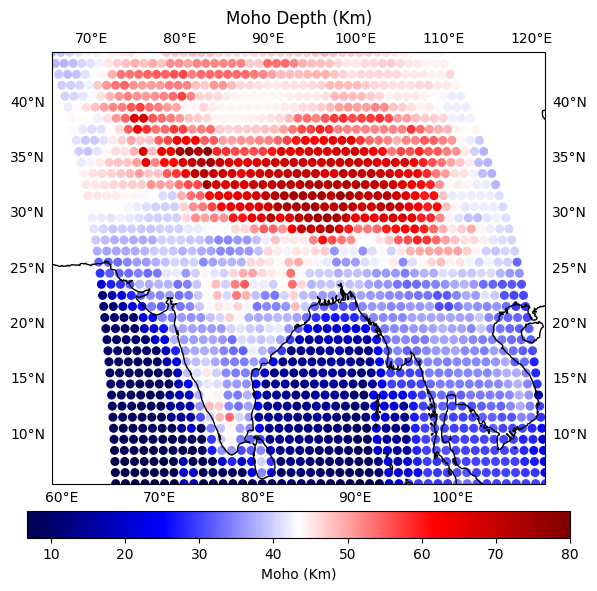

In [10]:
def plot_moho(coordinates, moho, title_data):
    "Plot Moho data on a single map"
    fig, ax = plt.subplots(
        figsize=(7, 7),
        subplot_kw=dict(projection=ccrs.Robinson())
    )
    
    crs = ccrs.PlateCarree()
    
    # Define region from coordinate data
    region = [
        data_moho.longitude.min(), data_moho.longitude.max(), 
        data_moho.latitude.min(), data_moho.latitude.max()
    ]
  
    ax.set_extent(region, crs=crs)
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, crs=crs, alpha=0)
   
    ax.set_title(title_data)
    maxabs = np.nanmax(np.abs(moho))  
    minabs = np.nanmin(np.abs(moho))
    pc = ax.scatter(
        *coordinates,
        c=moho,
        s=30,
        cmap="seismic",
        vmin=minabs,
        vmax=maxabs,
        transform=crs,
    )
    plt.colorbar(pc, ax=ax, orientation="horizontal", pad=0.05).set_label("Moho (Km)")
    plt.show()

# Example usage:
plot_moho(
    (data_moho.longitude, data_moho.latitude),
    data_moho.Moho,
    "Moho Depth (Km)"
)


# Spline Interpolation

In [11]:
data = data_eq
coordinates=(data.Long, data.Lat)
moho=data.Moho_km
data
#print (moho)

Lat      Long  Moho_km
0      5.1800   96.9600     38.2
1      5.2288   96.9472     31.9
2      5.2900  100.6490     33.8
3      5.2902  100.6490     32.8
4      6.0870   80.6810     36.7
...       ...       ...      ...
5044  45.0000   82.0000     44.4
5045  45.0000   82.5000     36.8
5046  45.0000   83.0000     43.4
5047  45.0000   90.5000     41.0
5048  45.0000  107.1000     41.4

[5049 rows x 3 columns]

# Projection, Coordinates, Region and Spacing

In [12]:
coordinates = (data.Long.values, data.Lat.values)
region = vd.get_region(coordinates)

# Use a Mercator projection for our Cartesian gridder
projection = pyproj.Proj(proj="merc", lat_ts=data.Lat.mean())
print(region)
print(coordinates)

# The output grid spacing will 6 arc-minutes. If n/60 then x arc minutes
#spacing = 6 / 60
spacing = 1

(np.float64(67.7154), np.float64(110.0), np.float64(5.18), np.float64(45.0))
(array([ 96.96  ,  96.9472, 100.649 , ...,  83.    ,  90.5   , 107.1   ]), array([ 5.18  ,  5.2288,  5.29  , ..., 45.    , 45.    , 45.    ]))


### Spline weighted

In [13]:
%%time
# This spline will automatically perform cross-validation and search for the optimal parameter configuration.
spline = vd.SplineCV(dampings=(1e-5, 1e-3))

spline.fit(projection(*coordinates), data.Moho_km)

# Spline Score and Dampings: Use only when usinge SplineCV otherwise comment the Score and Damping Prints
# We can show the best R² score obtained in the cross-validation
#print("\nScore: {:.3f}".format(spline.scores_.max())) # only for SplineCV

# And then the best damping parameter that produced this high score.
#print("\nBest damping:", spline.damping_) # only for SplineCV

# Now we can create a geographic grid of air temperature by providing a
# projection function to the grid method and mask points that are too far from
# the observations
grid_full = spline.grid(
    region=region,
    spacing=spacing,
    projection=projection,
    dims=["latitude", "longitude"],
    data_names="moho",
)

grid = vd.distance_mask(
    coordinates, maxdist=3 * spacing * 111e3, grid=grid_full, projection=projection
)

C:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\verde\spline.py:245: FutureWarning: The mindist parameter of verde.Spline is no longer required and will be removed in Verde 2.0.0. Use the default value to obtain the future behavior.
  spline = Spline(**params)
C:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:129: FutureWarning: The mindist parameter of verde.Spline is no longer required and will be removed in Verde 2.0.0. Use the default value to obtain the future behavior.
  new_object = klass(**new_object_params)
C:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\verde\model_selection.py:784: FutureWarning: The default scoring will change from R² to negative root mean squared error (RMSE) in Verde 2.0.0. This may change model selection results slightly.
  score = estimator.score(*test_data)
C:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:129: FutureWarning: The 

CPU times: total: 1min 30s
Wall time: 17.8 s


In [14]:
spline

SplineCV(dampings=(1e-05, 0.001), mindists=[0])

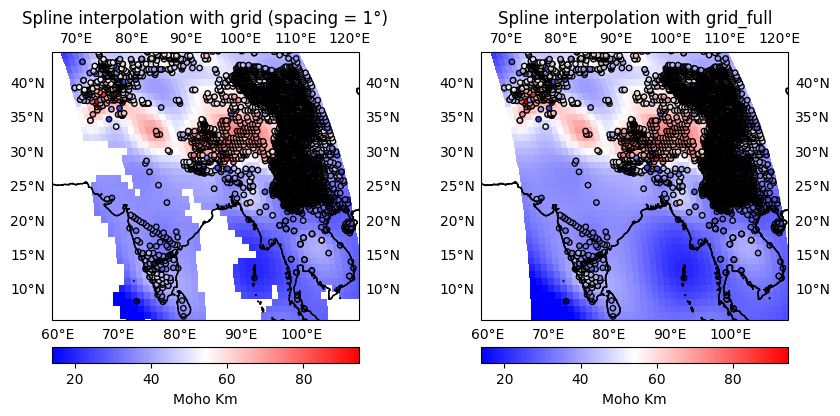

In [15]:
fig, axes = plt.subplots(
    1, 2, figsize=(9.5, 7), subplot_kw=dict(projection=ccrs.Robinson())
)
crs = ccrs.PlateCarree()
region = [
        data_moho.longitude.min(), data_moho.longitude.max(), 
        data_moho.latitude.min(), data_moho.latitude.max()
    ]
fig.subplots_adjust(wspace=0.4)  # Increase space (default is 0.2)
for ax in axes:
    ax.set_extent(region, crs=crs)  # Set region for both subplots
    ax.coastlines()  # Add coastlines
    #ax.add_feature(cfeature.BORDERS, linestyle=':')  # Add national boundaries
    gl = ax.gridlines(draw_labels=True, crs=crs, alpha=0)

# Plot Moho data in the first subplot
ax = axes[0]
ax.set_title(f"Spline interpolation with grid (spacing = {spacing}°)")
maxabs = np.nanmax(np.abs(moho))  
minabs = np.nanmin(np.abs(moho))
pc = grid.moho.plot.pcolormesh(
    ax=ax,
    cmap="bwr",
    vmin=minabs,
    vmax=maxabs,
    transform=crs,
    add_colorbar=False,
    add_labels=False,
)
plt.colorbar(pc, ax=ax, orientation="horizontal", pad=0.05).set_label("Moho Km")
ax.plot(data.Long, data.Lat, ".k", markersize=0.1, transform=crs)
ax.coastlines()

# Add scatter plot for Moho depths
sc = ax.scatter(
    eq_info.Long,  # Ensure correct coordinate for longitude
    eq_info.Lat,   # Ensure correct coordinate for latitude
    c=eq_info.Moho_km,  # Moho depth values for coloring
    cmap='bwr',  # Color map
    s=15,  # Adjust size of the points
    edgecolors='black',  # Black edges for points
    vmin=minabs,  # Set vmin consistent with pcolormesh
    vmax=maxabs,  # Set vmax consistent with pcolormesh
    transform=crs  # Use Cartopy's coordinate system
)

# Print eq_info to check data
#print(eq_info)

# Add colorbar for the Moho depth
#cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=0.05)
#cbar.set_label("RF Moho Depth [Km]")

ax = axes[1]
ax.set_title("Spline interpolation with grid_full")
maxabs = np.nanmax(np.abs(moho))  
minabs = np.nanmin(np.abs(moho))
pc = grid_full.moho.plot.pcolormesh(
    ax=ax,
    cmap="bwr",
    vmin=minabs,
    vmax=maxabs,
    transform=crs,
    add_colorbar=False,
    add_labels=False,
)
plt.colorbar(pc, ax=ax, orientation="horizontal", pad=0.05).set_label("Moho Km")
ax.plot(data.Long, data.Lat, ".k", markersize=0.1, transform=crs)
ax.coastlines()

# Add scatter plot for Moho depths
sc = ax.scatter(
    eq_info.Long,  # Ensure correct coordinate for longitude
    eq_info.Lat,   # Ensure correct coordinate for latitude
    c=eq_info.Moho_km,  # Moho depth values for coloring
    cmap='bwr',  # Color map
    s=15,  # Adjust size of the points
    edgecolors='black',  # Black edges for points
    vmin=minabs,  # Set vmin consistent with pcolormesh
    vmax=maxabs,  # Set vmax consistent with pcolormesh
    transform=crs  # Use Cartopy's coordinate system
)

#plt.colorbar(pc, ax=ax, orientation="horizontal", pad=0.05).set_label("Km")
ax.plot(data.Long, data.Lat, ".k", markersize=0.1, transform=crs)
ax.coastlines()
plt.show()

In [16]:
t=grid.moho.as_numpy()
p=grid_full.moho.as_numpy()

In [17]:
grid
# Convert the xarray Dataset to a pandas DataFrame
grid_df = grid.to_dataframe().reset_index()
grid_full_df = grid_full.to_dataframe().reset_index()
print(len(grid_full_df))
# Save as CSV
#grid_full_df.to_csv("grid_data.csv", index=False)

#print("CSV file saved: grid_data.csv")

1763


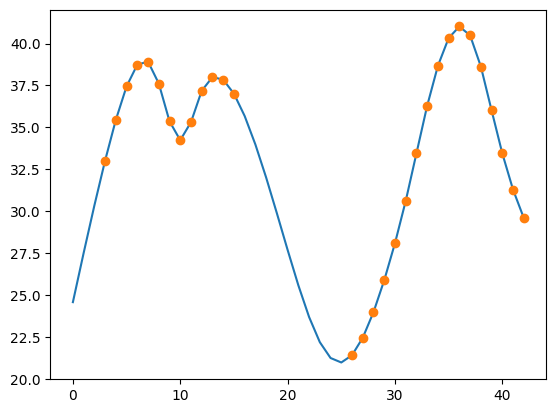

In [18]:
plt.plot(p.values[10])
plt.plot(t.values[10],'o')

# Weight Distribution

## Standard Deviation of Spline wrt RF

In [19]:
# Extract coordinates and RF Moho values
rf_lat = data_eq.Lat.values
rf_lon = data_eq.Long.values
rf_moho = data_eq.Moho_km.values

# Interpolate the spline Moho values at RF locations
spline_moho = spline.predict(projection(rf_lon, rf_lat))


# Compute the overall standard deviation (STD) of the residuals (RF Moho - Spline Moho)
overall_std = np.std(rf_moho - spline_moho)

# Compute pointwise variance (squared error) for each data point
pointwise_variance = abs((rf_moho - spline_moho)) #** 2

# Create a new DataFrame with latitude, longitude, RF Moho, Spline Moho, and pointwise variance
df = pd.DataFrame({
    "latitude": rf_lat,
    "longitude": rf_lon,
    "rf_moho": rf_moho,
    "spline_moho": spline_moho,
    "err_moho": pointwise_variance  # Variance (squared error)
})

# Print summary
print(df)
print("\nOverall STD of Spline relative to RF Moho:", overall_std)
#df.to_csv("spline_data.csv", index=False)

      latitude  longitude  rf_moho  spline_moho  err_moho
0       5.1800    96.9600     38.2    34.932096  3.267904
1       5.2288    96.9472     31.9    34.880468  2.980468
2       5.2900   100.6490     33.8    31.546979  2.253021
3       5.2902   100.6490     32.8    31.546799  1.253201
4       6.0870    80.6810     36.7    34.967984  1.732016
...        ...        ...      ...          ...       ...
5044   45.0000    82.0000     44.4    43.201229  1.198771
5045   45.0000    82.5000     36.8    43.258890  6.458890
5046   45.0000    83.0000     43.4    43.715373  0.315373
5047   45.0000    90.5000     41.0    43.546808  2.546808
5048   45.0000   107.1000     41.4    43.022031  1.622031

[5049 rows x 5 columns]

Overall STD of Spline relative to RF Moho: 4.658748611478851


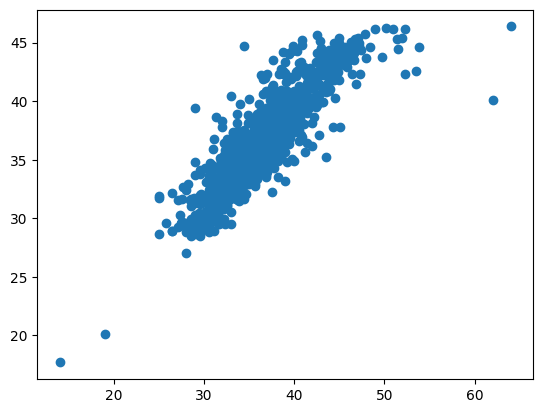

In [20]:
plt.scatter(x=data_eq['Moho_km'][0:1000],y=spline_moho[0:1000])

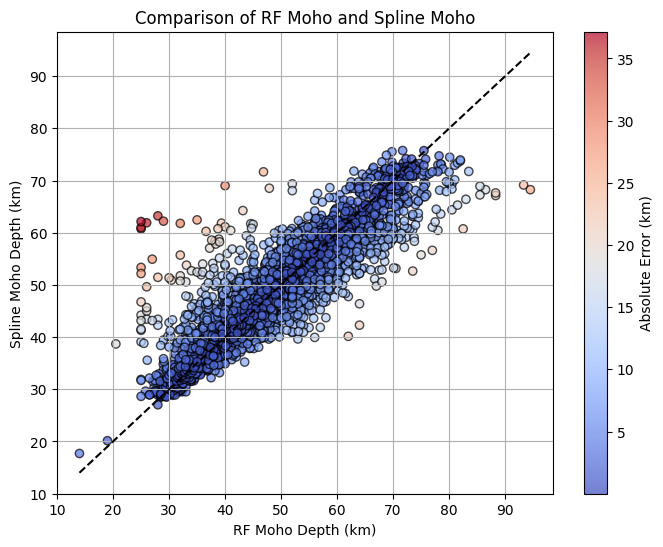

In [21]:
plt.figure(figsize=(8, 6))
plt.scatter(df["rf_moho"], df["spline_moho"], c=df["err_moho"], cmap="coolwarm", edgecolor="k", alpha=0.7)
plt.plot([df["rf_moho"].min(), df["rf_moho"].max()], [df["rf_moho"].min(), df["rf_moho"].max()], 'k--')  # 1:1 line
plt.colorbar(label="Absolute Error (km)")
plt.xlabel("RF Moho Depth (km)")
plt.ylabel("Spline Moho Depth (km)")
plt.title("Comparison of RF Moho and Spline Moho")
plt.grid(True)
plt.show()


In [22]:
data_moho.head

<bound method NDFrame.head of       longitude  latitude   Moho
0          65.5      44.5  38.31
1          66.5      44.5  39.22
2          67.5      44.5  40.41
3          68.5      44.5  41.65
4          69.5      44.5  42.31
...         ...       ...    ...
1795      105.5       5.5  29.93
1796      106.5       5.5  29.93
1797      107.5       5.5  29.93
1798      108.5       5.5  29.90
1799      109.5       5.5  28.87

[1800 rows x 3 columns]>

In [23]:
# Create a KDTree for RF locations
rf_tree = cKDTree(list(zip(df.longitude, df.latitude)))

# Assign RF Moho directly where RF exists (100% weight to RF)
df["weighted_moho"] = df["rf_moho"]

# Create 1°x1° bins and check which bins have no RF data
df["lat_bin"] = (df["latitude"] // 1) * 1
df["lon_bin"] = (df["longitude"] // 1) * 1

data_moho["lat_bin"] = (data_moho["latitude"] // 1) * 1
data_moho["lon_bin"] = (data_moho["longitude"] // 1) * 1

rf_bins = set(zip(df["lat_bin"], df["lon_bin"]))
all_bins = set(zip(data_moho["lat_bin"], data_moho["lon_bin"]))

# Identify bins with no RF data
missing_rf_bins = all_bins - rf_bins
df_no_rf = data_moho[data_moho[["lat_bin", "lon_bin"]].apply(tuple, axis=1).isin(missing_rf_bins)].copy()

# Assign Crust1.0 Moho first
df_no_rf["weighted_moho"] = df_no_rf["Moho"]


# Find the nearest RF node for each location without RF
_, nearest_rf_idx = rf_tree.query(list(zip(df_no_rf.longitude, df_no_rf.latitude)))

# Get **precomputed** spline_moho from the nearest RF node
df_no_rf["nearest_rf_spline_moho"] = df.spline_moho.iloc[nearest_rf_idx].values

# Predict spline Moho for each missing RF location using the global spline
df_no_rf["nearest_rf_spline_moho"] = spline.predict(
    projection(df_no_rf.longitude, df_no_rf.latitude)
)

# Compute x and y using the **precomputed nearest RF spline Moho**
x = df_no_rf["nearest_rf_spline_moho"] - df_no_rf["weighted_moho"]
y = abs(x)

# Apply updated weighting logic
df_no_rf["weighted_moho"] = np.where(
    y < overall_std,  
    df_no_rf["nearest_rf_spline_moho"],  # If error is small, use nearest RF spline Moho
    0.4 * df_no_rf["nearest_rf_spline_moho"] + 0.6 * df_no_rf["weighted_moho"]  # Otherwise, use weighted combination
)

# Combine both datasets
df_final = pd.concat([df, df_no_rf], ignore_index=True)

# Save to CSV
#df_final.to_csv("weighted_moho.csv", index=False)

# Print summary
print(df_final)


      latitude  longitude  rf_moho  spline_moho  err_moho  weighted_moho  \
0       5.1800    96.9600     38.2    34.932096  3.267904      38.200000   
1       5.2288    96.9472     31.9    34.880468  2.980468      31.900000   
2       5.2900   100.6490     33.8    31.546979  2.253021      33.800000   
3       5.2902   100.6490     32.8    31.546799  1.253201      32.800000   
4       6.0870    80.6810     36.7    34.967984  1.732016      36.700000   
...        ...        ...      ...          ...       ...            ...   
6194    5.5000   105.5000      NaN          NaN       NaN      28.819104   
6195    5.5000   106.5000      NaN          NaN       NaN      28.155746   
6196    5.5000   107.5000      NaN          NaN       NaN      27.326326   
6197    5.5000   108.5000      NaN          NaN       NaN      26.324878   
6198    5.5000   109.5000      NaN          NaN       NaN      25.158719   

      lat_bin  lon_bin   Moho  nearest_rf_spline_moho  
0         5.0     96.0    NaN  

In [24]:
df_final['weighted_moho']

0       38.200000
1       31.900000
2       33.800000
3       32.800000
4       36.700000
          ...    
6194    28.819104
6195    28.155746
6196    27.326326
6197    26.324878
6198    25.158719
Name: weighted_moho, Length: 6199, dtype: float64

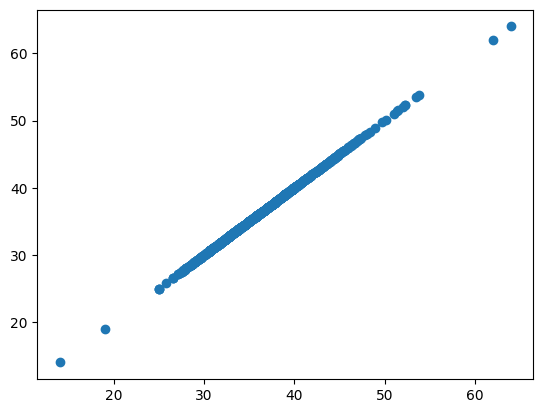

In [25]:
plt.scatter(x=data_eq['Moho_km'][0:1000],y=df_final['weighted_moho'][0:1000])

No. of times Crust1.0 falls under close proximity of RFs: 579
514
6199
      latitude  longitude  weighted_moho
0         44.5       65.5      28.706297
1         44.5       66.5      30.630873
2         44.5       67.5      32.735785
3         44.5       68.5      34.901489
4         44.5       69.5      36.777682
...        ...        ...            ...
1780       5.5       90.5      16.976002
1781       5.5       91.5      17.595357
1782       5.5       92.5      18.842893
1783       5.5       93.5      25.498836
1784       5.5       94.5      25.577965

[579 rows x 3 columns]


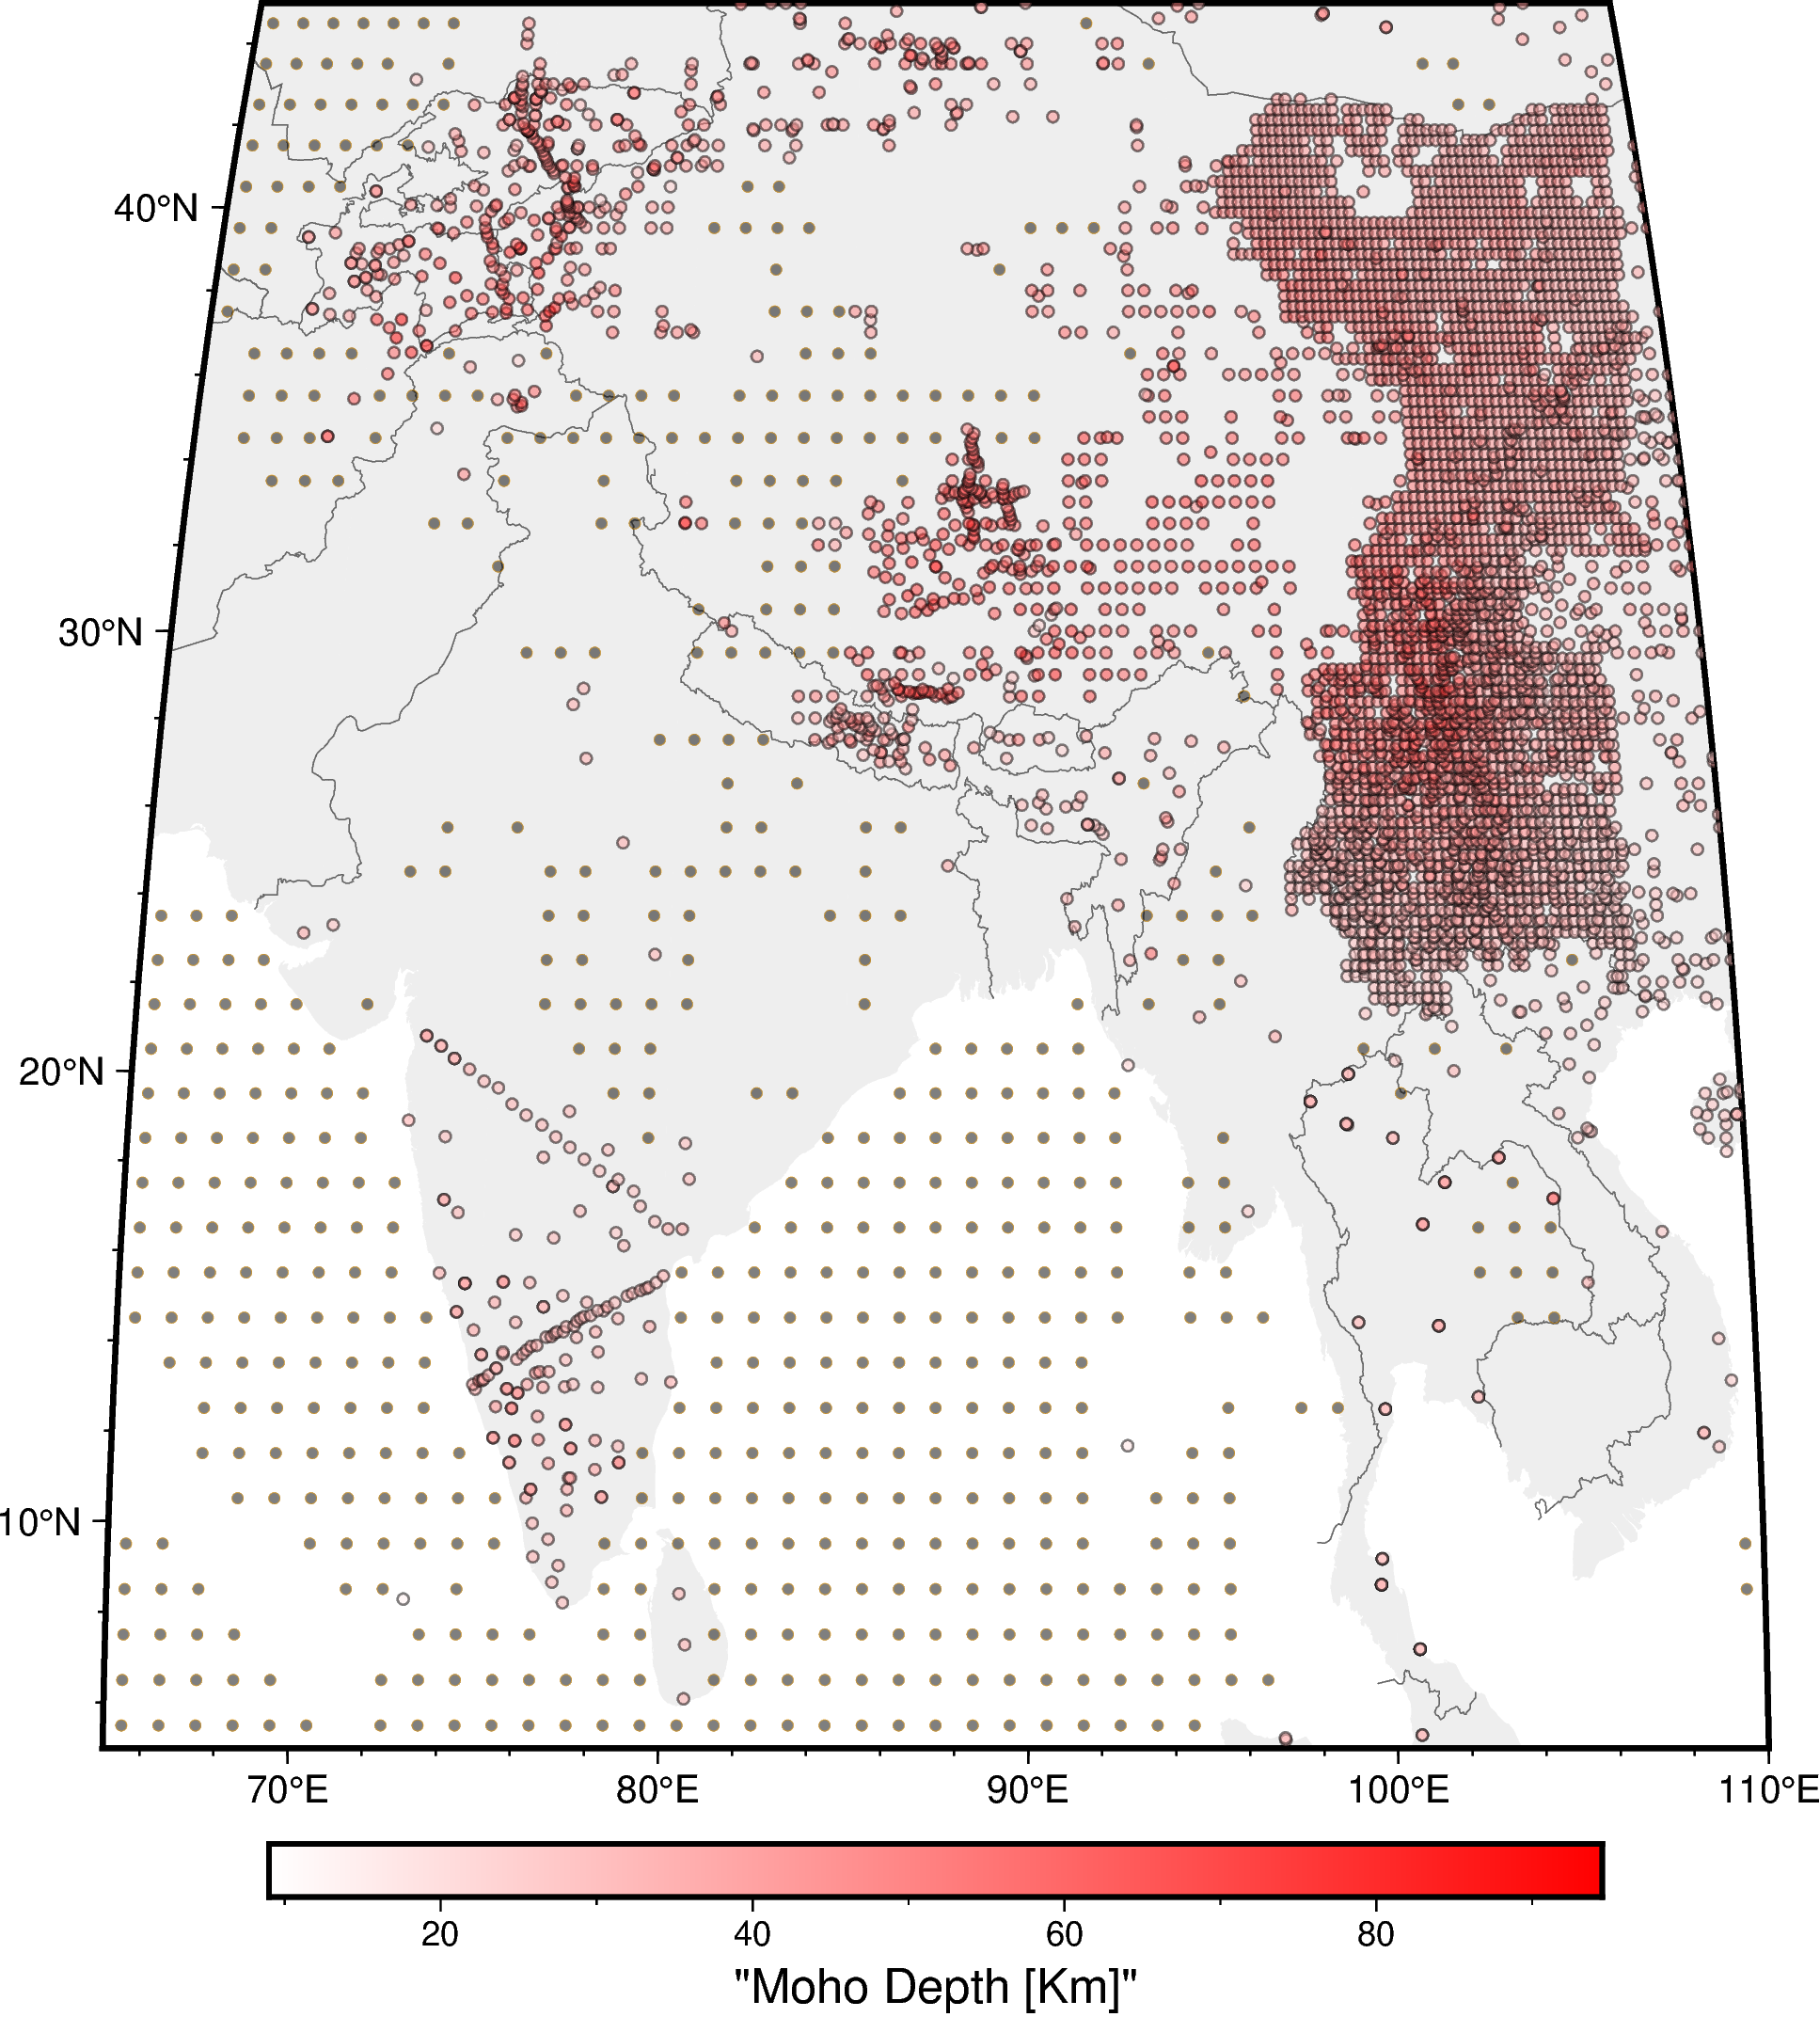

In [26]:
# Count occurrences where y < overall_std
count_close_proximity = (y > overall_std).sum()
c = (x < 0).sum()
# Print the result
print(f"No. of times Crust1.0 falls under close proximity of RFs: {count_close_proximity}")
print (c)
print(len(df_final))

# Filter the dataframe where x < 0
#df_condition = df_no_rf[x < 0][["latitude", "longitude", "weighted_moho"]]
df_condition = df_no_rf[y > overall_std][["latitude", "longitude", "weighted_moho"]]
# Display the filtered dataframe
print(df_condition)
region = [65, 110, 5, 45]
# Start a figure
fig = pygmt.Figure()
# Add a basemap with the data region, Mercator projection, default frame
# and ticks, color in the continents, and display national borders
fig.coast(
    region=region, projection="W15c", frame="af",
    land="#eeeeee", borders="1/#666666", area_thresh=1e4,
)
# Create a colormap for the Moho Depth
pygmt.makecpt(
    cmap="polar+h",
    series=[data_eq_all.Moho_km.min(), data_eq_all.Moho_km.max()],
    #series = [data.iloc[:, 5].min(), data.iloc[:, 5].max()],
)
fig.plot(
    x=data_eq.Long,
    y=data_eq.Lat,
    fill=data_eq.Moho_km,
    style="c0.1c",
    cmap=True,
    pen="0.5p,black",transparency=50
)
# Plot colored points for the velocities
fig.plot(
    x=df_condition.longitude,
    y=df_condition.latitude,
    #fill=data_eq_all.Moho_km,
    style="c0.1c",
    cmap=True,
    pen="0.1p,orange",transparency=50
)
# Add a colorbar with automatic frame and ticks and a label
fig.colorbar(frame='af+l"Moho Depth [Km]"')
fig.show()
#fig.savefig("/home/amitava/Downloads/test.png", dpi=300)
fig.savefig(r"C:\Users\DELL\Downloads\test.png", dpi=300)

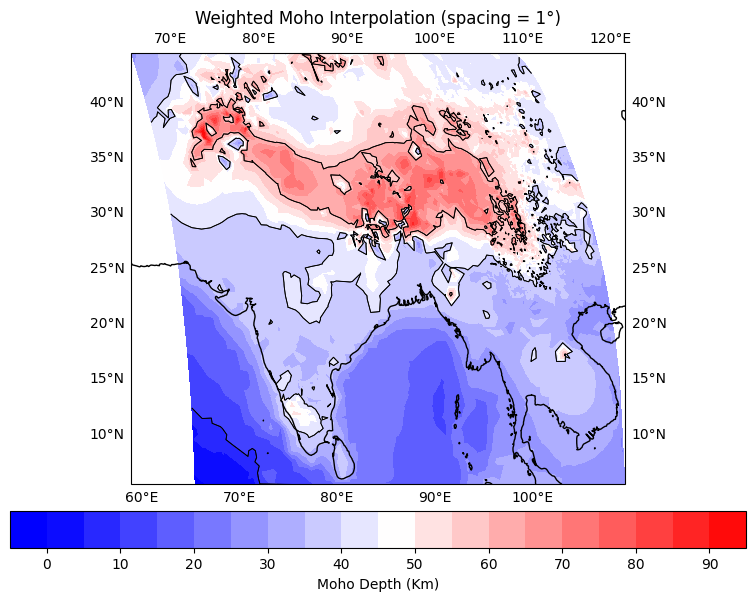

In [27]:

# Global
region = [
    data_moho.longitude.min(), data_moho.longitude.max(),
    data_moho.latitude.min(), data_moho.latitude.max()
]

fig, ax = plt.subplots(
    figsize=(9.5, 7),
    subplot_kw=dict(projection=ccrs.Robinson())
)
'''

# Local

region = [65, 110, 5, 45]

fig, ax = plt.subplots(
    figsize=(9.5, 7),
    subplot_kw=dict(projection=ccrs.Mercator())
)
'''
crs = ccrs.PlateCarree()

ax.set_extent(region, crs=crs)
ax.coastlines()
ax.gridlines(draw_labels=True, crs=crs, alpha=0)

ax.set_title(f"Weighted Moho Interpolation (spacing = {spacing}°)")
maxabs = np.nanmax(np.abs(df_final.weighted_moho))
minabs = np.nanmin(np.abs(df_final.weighted_moho))

pc = ax.tricontourf(
    df_final.longitude, df_final.latitude, df_final.weighted_moho,
    cmap="bwr", levels=20, vmin=minabs, vmax=maxabs, transform=crs
)

ax.tricontour(
    df_final.longitude, df_final.latitude, df_final.weighted_moho,
    levels=[10, 40, 60], transform=crs, colors='black', linewidths=0.5
)

cbar = plt.colorbar(pc, ax=ax, orientation="horizontal", pad=0.05)
cbar.set_label("Moho Depth (Km)")
cbar.locator = MaxNLocator(integer=True)
cbar.update_ticks()

pc_1 = ax.tricontour(
    df_final.longitude, df_final.latitude, df_final.weighted_moho,
    levels=[10, 40, 60],
    colors='black',         # make contours clearly visible
    linewidths=0.7,
    transform=crs
)
'''
# Add earthquakes on the same plot
ax.scatter(
    eq_info.Long, eq_info.Lat, c=eq_info.Moho_km,
    cmap='bwr', s=5, edgecolors='black',
    vmin=minabs, vmax=maxabs, transform=crs
)
'''
plt.show()
fig.savefig(r"C:/Users/DELL/Pictures/Screenshots/final_moho_depth_map.png", dpi=300)


# Data Points on Ocean

In [ ]:
'''
region = [-180, 180, -90, 90] 

# Generate a land-sea mask (0 = ocean, 1 = land)
mask = pygmt.grdlandmask(
    spacing="5m", region="g", resolution="low", maskvalues=[0, 1]
)

# Extract ocean points where mask value is 0 (ocean)
mask_values = pygmt.grdtrack(
    points=data_eq_all[["Long", "Lat"]],
    grid=mask,
    newcolname="mask"
)

# Filter ocean points (where mask == 0)
ocean_points = data_eq_all[mask_values["mask"] == 0]

# Save ocean locations to CSV
#ocean_points.to_csv("ocean_locations.csv", index=False)
#print("Ocean locations saved to ocean_locations.csv")
'''
import pandas as pd
from scipy.spatial import cKDTree
import numpy as np

# Ensure your data has the right columns
# data_moho: columns ['Lat', 'Long', 'moho']
# data_eq: columns ['Lat', 'Long', 'Moho_km']

# Step 1: Build a KDTree from data_moho lat/lon
moho_coords = data_moho[["latitude", "longitude"]].to_numpy()
moho_tree = cKDTree(moho_coords)

# Step 2: Query nearest grid point in moho data within 1 degree
eq_coords = data_eq[["Lat", "Long"]].to_numpy()
distances, indices = moho_tree.query(eq_coords, distance_upper_bound=0.5)

# Step 3: Initialize a mask for valid matches
valid = distances != np.inf

# Get matched moho values only where distance ≤ 1°
matched_moho = np.full(len(data_eq), np.nan)
matched_moho[valid] = data_moho.iloc[indices[valid]]["Moho"].values

# Step 4: Compute absolute difference and filter >15 km
moho_diff = np.abs(data_eq["Moho_km"] - matched_moho)
mask = moho_diff > 30

# Step 5: Create final ocean_points DataFrame
ocean_points = data_eq[mask & valid].copy()

# Optional: add the difference column for inspection
ocean_points["Moho_diff_km"] = moho_diff[mask & valid]

# ocean_points now contains only points where Moho_km differs by >15 km from reference
# You can save or inspect:
# ocean_points.to_csv("moho_mismatch_ocean_points.csv", index=False)


In [ ]:

# Create figure
fig = pygmt.Figure()

# Define projection and region
fig.coast(
    region=region, projection="W15c", frame="af",
    land="#eeeeee", borders="1/#666666", area_thresh=1e4,
)

# Create colormap based on Moho depth
pygmt.makecpt(
    cmap="polar+h",
    series=[data_eq["Moho_km"].min(), data_eq["Moho_km"].max()],
)

# Plot Moho depth points with color scaling
fig.plot(
    x=ocean_points["Long"], 
    y=ocean_points["Lat"], 
    fill=ocean_points["Moho_km"],  # Color based on Moho depth
    style="c0.2c", 
    cmap=True, 
    pen="0.5p,black",
)

# Add a colorbar for reference
fig.colorbar(frame='af+l"Moho Depth (km)"')

# Show the plot
fig.show()
